# Libraries

In [1]:
import cv2
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision



from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

# Data

In [2]:
# list of files and folders available

! ls ../input/plant-pathology-2020-fgvc7

images	sample_submission.csv  test.csv  train.csv


In [3]:
# train.csv contains image_id (name of the image in the images folder) and 
# wheter it has any condition

train = pd.read_csv('../input/plant-pathology-2020-fgvc7/train.csv')
print(train.shape)
x = train.loc[:,["image_id"]]


(1821, 5)


In [4]:
# columns 
train.columns

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [5]:
# no. of images in each category 
train[['healthy', 'multiple_diseases', 'rust', 'scab']].sum()

healthy              516
multiple_diseases     91
rust                 622
scab                 592
dtype: int64

In [6]:
# test.csv contains image_id (name of the image in the images folder) for which we need to predict

test = pd.read_csv('../input/plant-pathology-2020-fgvc7/test.csv')
print(test.shape)
test.head()

(1821, 1)


,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


# Image paths

In [7]:
# image directory address
img_dir = '../input/plant-pathology-2020-fgvc7/images/'
img_dir2 = '../input/plant-pathology-2020-fgvc7/'
# list of all images names
imgs = os.listdir(img_dir)
print(imgs[:4])

# list of all images path
img_paths = glob.glob('../input/plant-pathology-2020-fgvc7/images/*')
print(img_paths[:3])

# train and test images path
train_imgs = glob.glob('../input/plant-pathology-2020-fgvc7/images/Train_*')
test_imgs = glob.glob('../input/plant-pathology-2020-fgvc7/images/Test_*')
print(train_imgs[:3])
print(test_imgs[:3])

['Test_1283.jpg', 'Train_1334.jpg', 'Test_865.jpg', 'Test_834.jpg']
['../input/plant-pathology-2020-fgvc7/images/Test_1283.jpg', '../input/plant-pathology-2020-fgvc7/images/Train_1334.jpg', '../input/plant-pathology-2020-fgvc7/images/Test_865.jpg']
['../input/plant-pathology-2020-fgvc7/images/Train_1334.jpg', '../input/plant-pathology-2020-fgvc7/images/Train_1055.jpg', '../input/plant-pathology-2020-fgvc7/images/Train_1526.jpg']
['../input/plant-pathology-2020-fgvc7/images/Test_1283.jpg', '../input/plant-pathology-2020-fgvc7/images/Test_865.jpg', '../input/plant-pathology-2020-fgvc7/images/Test_834.jpg']


# Images

### Healthy leaves

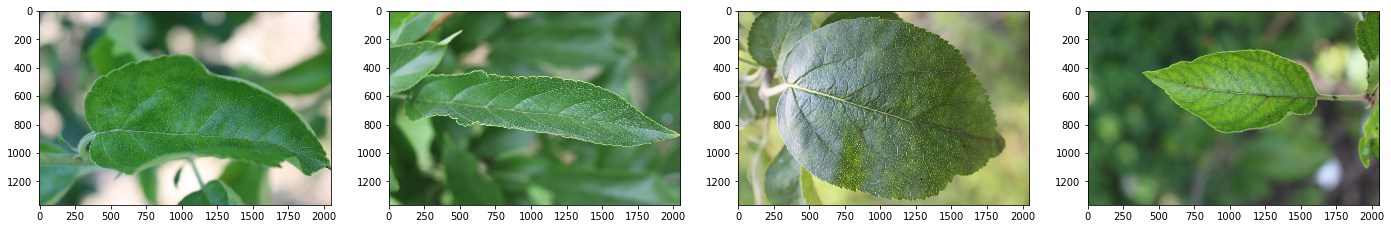

In [8]:
temp = train[train['healthy']==1]
img_ids = ['../input/plant-pathology-2020-fgvc7/images/'+i+'.jpg' for i in temp['image_id']]

plt.figure(figsize=(24, 5))
for ind, img in enumerate(img_ids[:4]):
    plt.subplot(1,4,ind+1)
    image = mpimg.imread(img) # read image
    plt.imshow(image)
#     image = cv2.imread(img)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     cv2.imshow('image', image)

### Leaves with multiple diseases

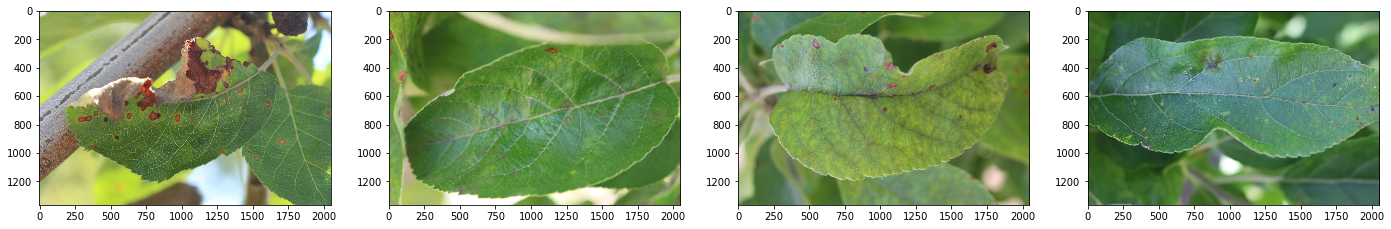

In [9]:
temp = train[train['multiple_diseases']==1]
img_ids = ['../input/plant-pathology-2020-fgvc7/images/'+i+'.jpg' for i in temp['image_id']]

plt.figure(figsize=(24, 5))
for ind, img in enumerate(img_ids[:4]):
    plt.subplot(1,4,ind+1)
    image = mpimg.imread(img) # read image
    plt.imshow(image)

### Leaves with rust

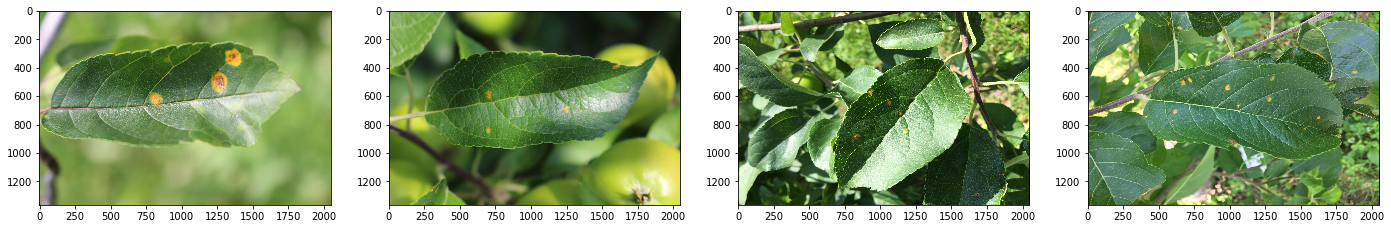

In [10]:
temp = train[train['rust']==1]
img_ids = ['../input/plant-pathology-2020-fgvc7/images/'+i+'.jpg' for i in temp['image_id']]

plt.figure(figsize=(24, 5))
for ind, img in enumerate(img_ids[:4]):
    plt.subplot(1,4,ind+1)
    image = mpimg.imread(img) # read image
    plt.imshow(image)

### Leaves with scab

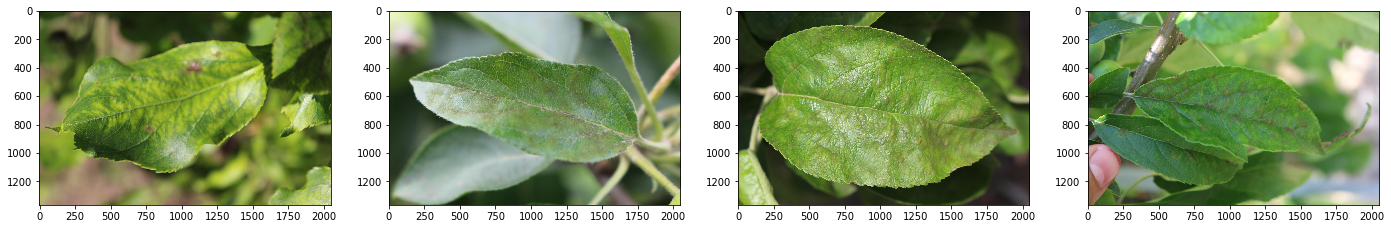

In [11]:
temp = train[train['scab']==1]
img_ids = ['../input/plant-pathology-2020-fgvc7/images/'+i+'.jpg' for i in temp['image_id']]

plt.figure(figsize=(24, 5))
for ind, img in enumerate(img_ids[:4]):
    plt.subplot(1,4,ind+1)
    image = mpimg.imread(img) # read image
    plt.imshow(image)

In [12]:
# for i in ['healthy', 'multiple_diseases', 'rust', 'scab']:
#     plt.figure(figsize=(24, 5))
#     plt.suptitle('Leaf condition: '+ i.title())
      
#     temp = train[train[i]==1]
#     img_ids = ['../input/plant-pathology-2020-fgvc7/images/'+i+'.jpg' for i in temp['image_id']]

#     plt.figure(figsize=(24, 5))
#     for ind, img in enumerate(img_ids[:5]):
#         plt.subplot(1,5,ind+1)
#         image = mpimg.imread(img) # read image
#         plt.imshow(image)

In [13]:
def image_path(img_id):
    return img_dir + img_id + '.jpg'

train_paths = train['image_id'].apply(image_path)
test_paths = test['image_id'].apply(image_path)

In [14]:
train_labels = np.float32(train.loc[:, 'healthy':'scab'].values)


In [15]:
!pip install torchsummary
from torchsummary import summary
DIR_INPUT = '/kaggle/input/plant-pathology-2020-fgvc7'
SIZE = 244
train_labels = train.iloc[:, 1:].values
train_y = train_labels[:, 2] + train_labels[:, 3] * 2 + train_labels[:, 1] * 3

y = train_labels


In [16]:
from PIL import Image
train_transforms = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224,224)), transforms.ToTensor()])

In [17]:
class PlantDataset(Dataset):
    
    def __init__(self, df, transforms=None):
    
        self.df = df
        self.transforms=transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        image_src = DIR_INPUT + '/images/' + self.df.loc[idx, 'image_id'] + '.jpg'
        # print(image_src)
        image = cv2.imread(image_src, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels = self.df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']].values
        labels = np.array(np.argmax(labels)) 
        labels = torch.from_numpy(labels.astype(np.int8)).long()
       
        
        if self.transforms:
            image = self.transforms(image)

        return image, labels
    





In [18]:
num_epochs = 1
num_classes = 10
batch_size = 40
learning_rate = 0.001
torch.cuda.is_available()



False

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*53*53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*53*53 )
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=0)
        return x
        
net = Net()
summary(net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
         MaxPool2d-2          [-1, 6, 110, 110]               0
            Conv2d-3         [-1, 16, 106, 106]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 120]       5,393,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 4]             340
Total params: 5,406,776
Trainable params: 5,406,776
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.49
Params size (MB): 20.63
Estimated Total Size (MB): 25.68
----------------------------------------------------------------


In [20]:
!pip install torchsummary
from torchsummary import summary
X_train, X_valid = train_test_split(train, test_size=0.33, random_state=42)
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)

dataset_train = PlantDataset(df=X_train, transforms=train_transforms)
BATCH_SIZE = 40
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2)

dataset_valid = PlantDataset(X_valid, transforms = train_transforms)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2)

dataset_test = PlantDataset(df=test, transforms=train_transforms)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

In [21]:
X_valid

,image_id,healthy,multiple_diseases,rust,scab
0,Train_1511,0,0,1,0
1,Train_1799,1,0,0,0
2,Train_135,1,0,0,0
3,Train_408,0,0,1,0
4,Train_1693,1,0,0,0
...,...,...,...,...,...
596,Train_1368,1,0,0,0
597,Train_221,1,0,0,0
598,Train_113,0,1,0,0
599,Train_1258,0,0,0,1


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(dataloader_train,0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 9 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print("done")
        
    

[1,     1] loss: 0.001
[1,    10] loss: 0.006
[1,    19] loss: 0.006
[1,    28] loss: 0.006
[2,     1] loss: 0.001
[2,    10] loss: 0.006
[2,    19] loss: 0.006
[2,    28] loss: 0.006
done


In [23]:
with torch.no_grad():
    correct = 0
    total = 0
    for i, data in enumerate(dataloader_valid):
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    print(f'accuracy: {correct/total*100}')
        
        


    

accuracy: 41.76372712146423


In [24]:
DIR_INPUT = '/kaggle/input/plant-pathology-2020-fgvc7'
submission_df = pd.read_csv(DIR_INPUT + '/sample_submission.csv')
submission_df.iloc[:, 1:] = 0
dataset_test = PlantDataset(df=submission_df, transforms=train_transforms)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)
test_preds = None

for step, batch in enumerate(dataloader_test):

    images = batch[0]
    
    with torch.no_grad():
        outputs = net(images)

        if test_preds is None:
            test_preds = outputs.data
        else:
            test_preds = torch.cat((test_preds, outputs.data), dim=0)


# Save predictions per fold
submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = torch.softmax(test_preds, dim=1)
submission_df.to_csv('submission.csv', index=False)
submission_df


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.241882,0.317522,0.220913,0.219683
1,Test_1,0.209649,0.173090,0.434436,0.182826
2,Test_2,0.277277,0.242283,0.205376,0.275064
3,Test_3,0.189239,0.143406,0.474620,0.192735
4,Test_4,0.191837,0.190876,0.296093,0.321194
...,...,...,...,...,...
1816,Test_1816,0.158186,0.305463,0.233286,0.303064
1817,Test_1817,0.212213,0.270717,0.220410,0.296659
1818,Test_1818,0.226379,0.231836,0.174735,0.367050
1819,Test_1819,0.212524,0.277071,0.184561,0.325844
